# Analysis of the top countries for accounts and email volume 📧

---





### Import some useful stuff

---



In [2]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Authenticate the user and initialize the BigQuery client.

In [4]:
auth.authenticate_user()

In [5]:
client = bigquery.Client(project="data-analytics-mate")

## Build Core Query

---

SQL query to aggregate the number of accounts and emails by country.

In [6]:
query = """

-- ======================================================================
-- Title: Top 10 Countries by Email and Account Activity
-- Description:
--   This query combines email interaction data (sent, opened, visited)
--   with account creation data to compute engagement metrics per country.
--   It then calculates country-level totals and ranks countries by:
--     1. Total accounts created
--     2. Total emails sent
--   Finally, it selects only the top 10 countries for each metric.
-- ======================================================================

WITH union_email_account_metrics AS (
  -- Part 1: Email interaction metrics (sent, opened, clicked)
  SELECT
        DATE_ADD(s.date, INTERVAL es.sent_date DAY) AS date, -- Message send date (session date + offset)
        sp.country,
        ac.send_interval,
        ac.is_verified,
        ac.is_unsubscribed,
        CAST(NULL AS INT64) AS account_cnt, -- Empty value for account count
        COUNT(DISTINCT es.id_message) AS sent_msg, -- Number of unique emails sent
        COUNT(DISTINCT eo.id_message) AS open_msg, -- Number of emails opened
        COUNT(DISTINCT ev.id_message) AS visit_msg -- Number of emails leading to visit
  FROM `DA.email_sent` es
   LEFT JOIN `DA.email_open` eo USING (id_message)
    LEFT JOIN `DA.email_visit` ev USING (id_message)
     JOIN `DA.account` ac ON es.id_account = ac.id
      JOIN `DA.account_session` acs ON ac.id = acs.account_id
       JOIN `DA.session` s USING (ga_session_id)
        JOIN `DA.session_params` sp USING (ga_session_id)
  GROUP BY date, country, send_interval, is_verified, is_unsubscribed

  UNION ALL

  -- Part 2: Account creation data (without email metrics)
  SELECT
        s.date, -- Session date when the account was created
        sp.country,
        ac.send_interval,
        ac.is_verified,
        ac.is_unsubscribed,
        COUNT(DISTINCT ac.id) AS account_cnt, -- Number of accounts created
        CAST(NULL AS INT64) AS sent_msg, -- Email metrics are missing
        CAST(NULL AS INT64) AS open_msg,
        CAST(NULL AS INT64) AS visit_msg
  FROM `DA.account` ac
   JOIN `DA.account_session` acs ON ac.id = acs.account_id
    JOIN `DA.session` s USING (ga_session_id)
     JOIN `DA.session_params` sp USING (ga_session_id)
  GROUP BY date, country, send_interval, is_verified, is_unsubscribed
),

group_by_all AS ( -- Aggregate the merged data by all metrics
  SELECT
        date,
        country,
        send_interval,
        is_verified,
        is_unsubscribed,
        SUM(account_cnt) AS account_cnt,
        SUM(sent_msg) AS sent_msg,
        SUM(open_msg) AS open_msg,
        SUM(visit_msg) AS visit_msg
  FROM union_email_account_metrics
  GROUP BY date, country, send_interval, is_verified, is_unsubscribed
),

country_totals AS ( -- Compute country-level totals
  SELECT *,
  SUM(account_cnt) OVER (PARTITION BY country) AS total_country_account_cnt, -- Total accounts per country
  SUM(sent_msg) OVER (PARTITION BY country) AS total_country_sent_cnt -- Total emails sent per country
  FROM group_by_all
),

country_ranks AS ( -- Add country ranking by metrics
  SELECT *,
  DENSE_RANK() OVER (ORDER BY total_country_account_cnt DESC) AS rank_total_country_account_cnt, -- Ranking by account count
  DENSE_RANK() OVER (ORDER BY total_country_sent_cnt DESC) AS rank_total_country_sent_cnt -- Ranking by email sent
  FROM country_totals
)

SELECT * -- Show only TOP-10 countries by either criterion
FROM country_ranks
WHERE rank_total_country_account_cnt <= 10 OR rank_total_country_sent_cnt <= 10
ORDER BY date;
"""

Run the query and convert the result to a pandas DataFrame.



In [7]:
%%time
query_job = client.query(query)
results = query_job.result()

CPU times: user 77.6 ms, sys: 8.32 ms, total: 85.9 ms
Wall time: 11.2 s


In [8]:
df = results.to_dataframe()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   date                            4553 non-null   dbdate
 1   country                         4553 non-null   object
 2   send_interval                   4553 non-null   Int64 
 3   is_verified                     4553 non-null   Int64 
 4   is_unsubscribed                 4553 non-null   Int64 
 5   account_cnt                     2790 non-null   Int64 
 6   sent_msg                        4121 non-null   Int64 
 7   open_msg                        4121 non-null   Int64 
 8   visit_msg                       4121 non-null   Int64 
 9   total_country_account_cnt       4553 non-null   Int64 
 10  total_country_sent_cnt          4553 non-null   Int64 
 11  rank_total_country_account_cnt  4553 non-null   Int64 
 12  rank_total_country_sent_cnt     4553 non-null   

In [10]:
df.describe()

,send_interval,is_verified,is_unsubscribed,account_cnt,sent_msg,open_msg,visit_msg,total_country_account_cnt,total_country_sent_cnt,rank_total_country_account_cnt,rank_total_country_sent_cnt
count,4553.0,4553.0,4553.0,2790.0,4121.0,4121.0,4121.0,4553.0,4553.0,4553.0,4553.0
mean,2.030969,0.730947,0.372282,7.644086,97.795195,34.725309,3.822859,2972.762354,56084.537887,4.931913,5.162311
std,2.141965,0.443516,0.483466,15.461162,332.82296,113.233547,12.424556,4312.532098,81277.826007,2.995269,3.310096
min,1.0,0.0,0.0,1.0,1.0,0.0,0.0,375.0,7897.0,1.0,1.0
25%,1.0,0.0,0.0,1.0,3.0,1.0,0.0,490.0,9483.0,2.0,2.0
50%,1.0,1.0,0.0,2.0,9.0,5.0,0.0,553.0,10181.0,5.0,5.0
75%,1.0,1.0,1.0,6.0,61.0,23.0,2.0,2687.0,51189.0,8.0,8.0
max,7.0,1.0,1.0,133.0,2734.0,962.0,117.0,12384.0,233503.0,10.0,11.0


In [11]:
print((df.isnull().mean() * 100).round(2).map(lambda x: f'{x}%'))

date                                0.0%
country                             0.0%
send_interval                       0.0%
is_verified                         0.0%
is_unsubscribed                     0.0%
account_cnt                       38.72%
sent_msg                           9.49%
open_msg                           9.49%
visit_msg                          9.49%
total_country_account_cnt           0.0%
total_country_sent_cnt              0.0%
rank_total_country_account_cnt      0.0%
rank_total_country_sent_cnt         0.0%
dtype: object


In [12]:
df['country'].unique()

array(['India', 'France', 'Taiwan', 'Canada', 'United States',
       'United Kingdom', 'China', 'Germany', 'Italy', 'Spain',
       'Singapore'], dtype=object)

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df['date'].nsmallest(1)

,date
0,2020-11-01


In [15]:
df['date'].nlargest(1)

,date
4546,2021-02-25


## Data analysis and visualization

---



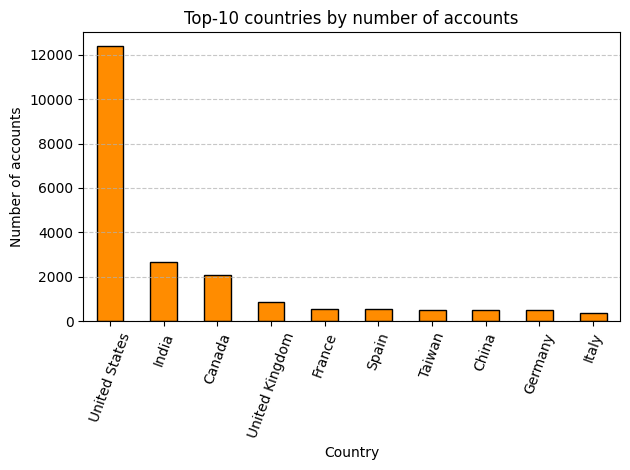

In [16]:
df_top_accounts = df.groupby('country')['account_cnt'].sum().sort_values(ascending=False).head(10)

df_top_accounts.plot(kind='bar', title='Top-10 countries by number of accounts', color='darkorange', edgecolor='k')
plt.ylabel('Number of accounts')
plt.xlabel('Country')
plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

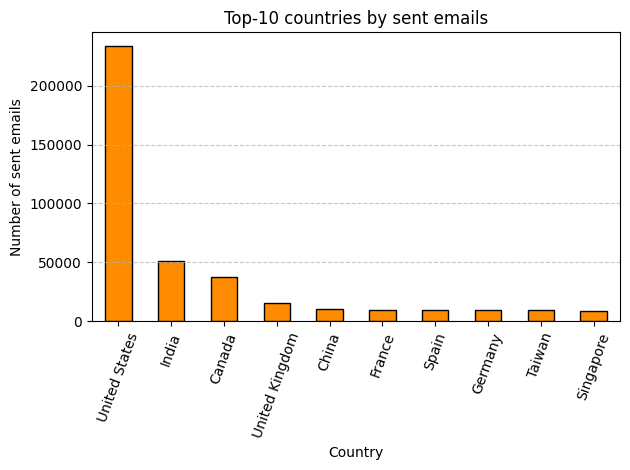

In [17]:
df_top_sent = df.groupby('country')['sent_msg'].sum().sort_values(ascending=False).head(10)

df_top_sent.plot(kind='bar', title='Top-10 countries by sent emails', color='darkorange', edgecolor='k')
plt.ylabel('Number of sent emails')
plt.xlabel('Country')
plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

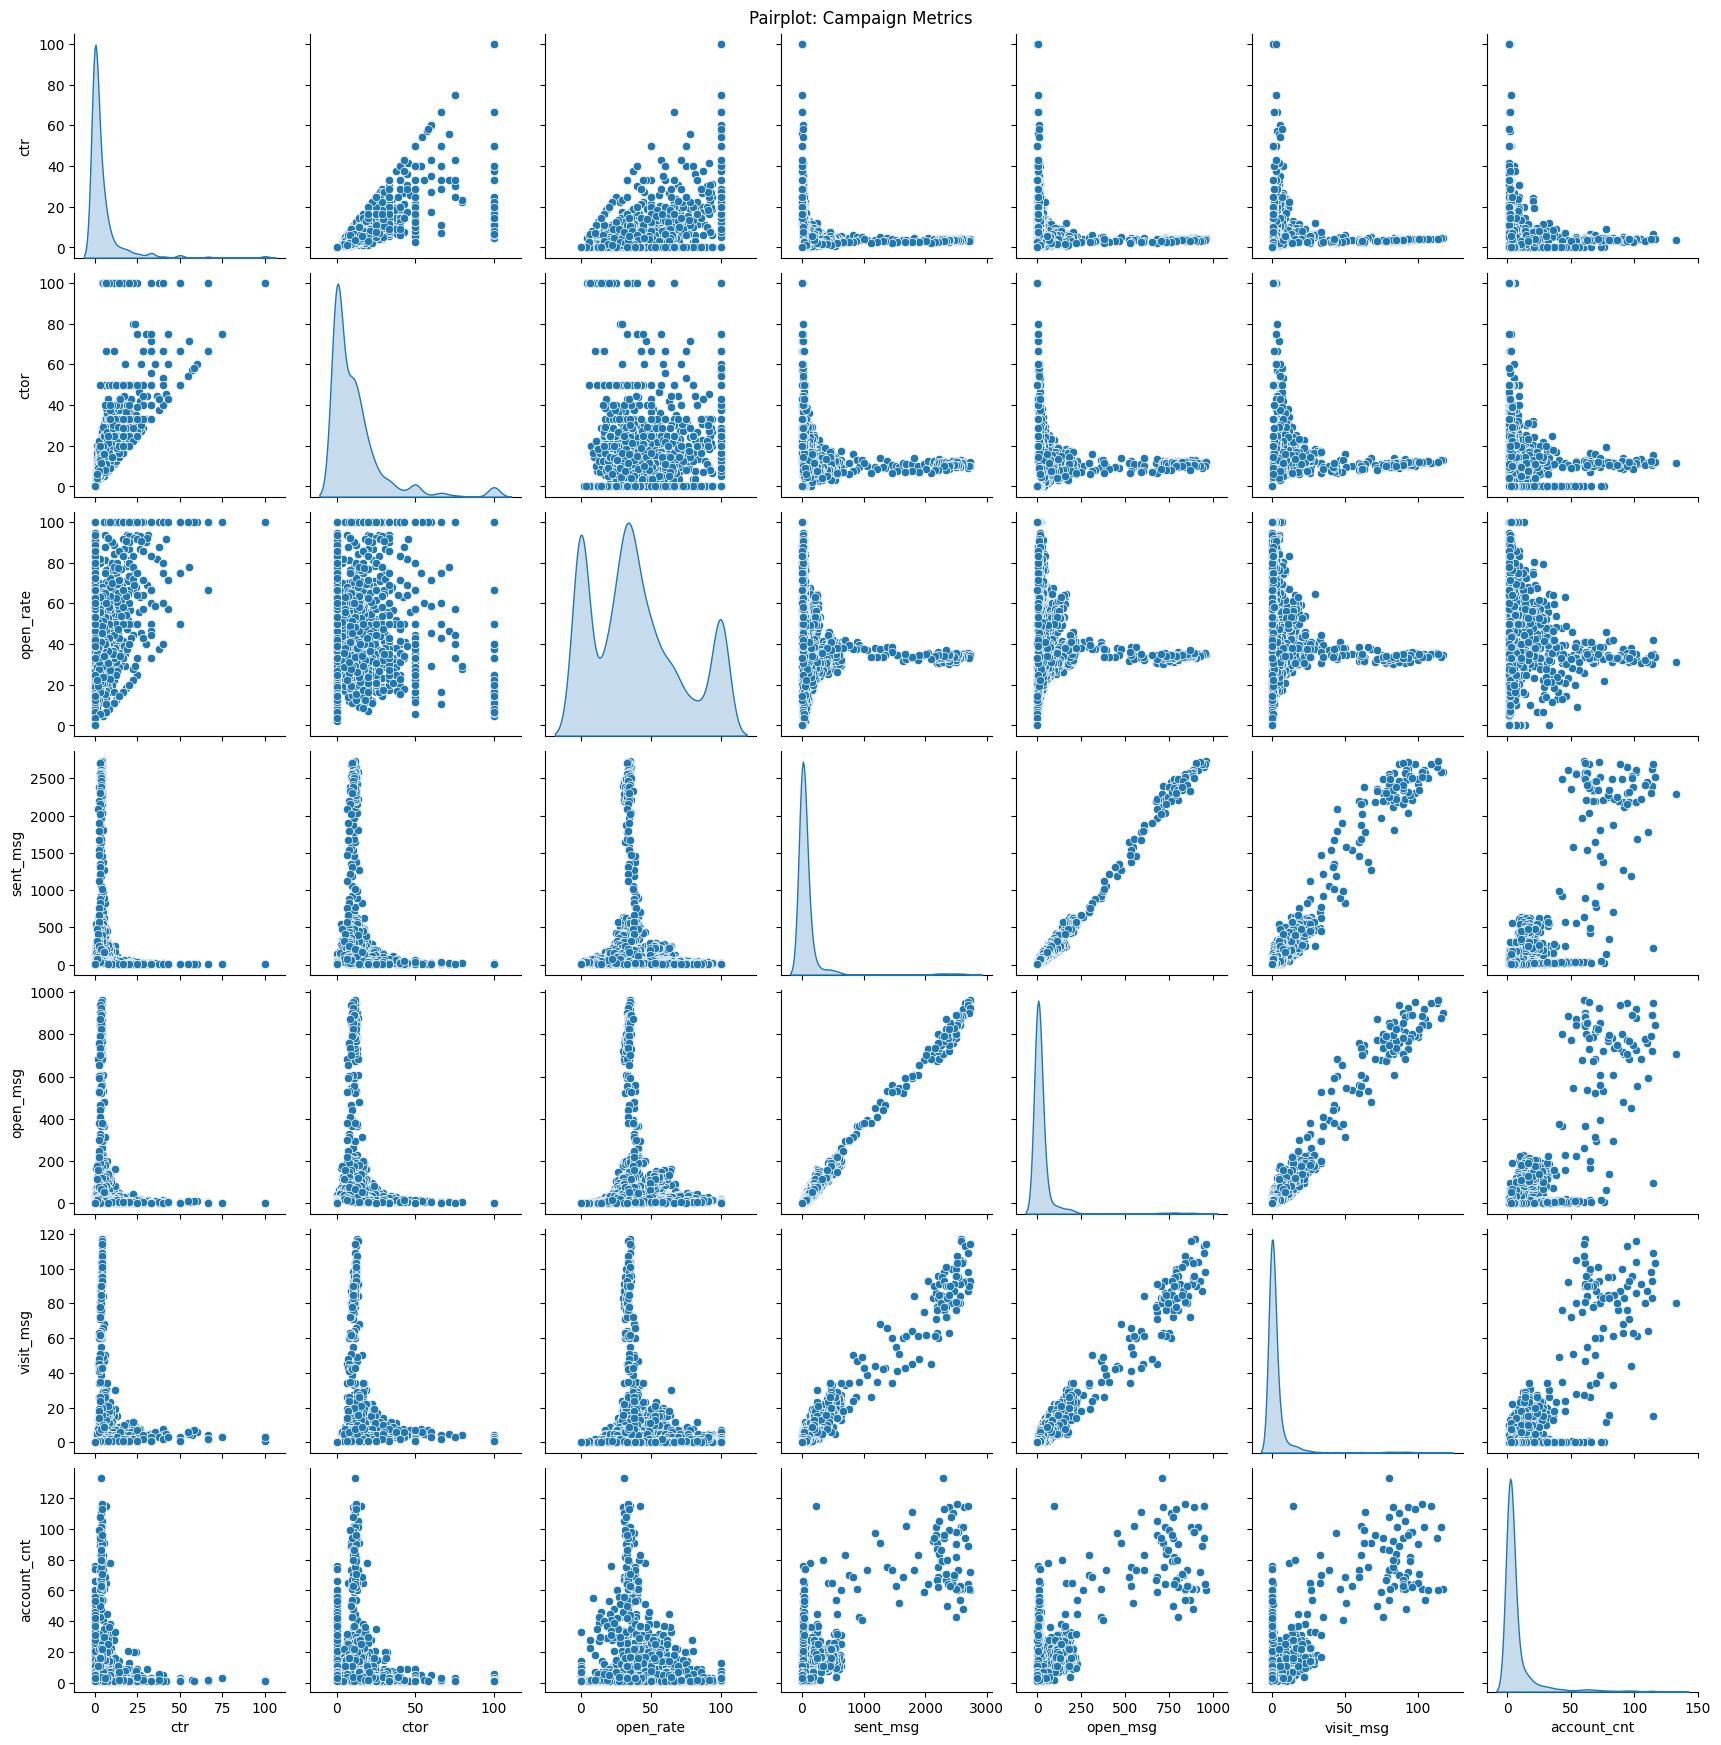

In [18]:
df['open_rate'] = df['open_msg'] / df['sent_msg'] * 100
df['ctr'] = df['visit_msg'] / df['sent_msg'] * 100
df['ctor'] = df['visit_msg'] / df['open_msg'] * 100

cols = ['ctr', 'ctor', 'open_rate', 'sent_msg', 'open_msg', 'visit_msg', 'account_cnt']

sns.pairplot(df[cols], diag_kind='kde')
plt.suptitle('Pairplot: Campaign Metrics', y=1)
plt.show()

In [19]:
merged_df = pd.concat([df_top_accounts, df_top_sent], axis=1)
merged_df.columns = ['accounts', 'sent_emails']

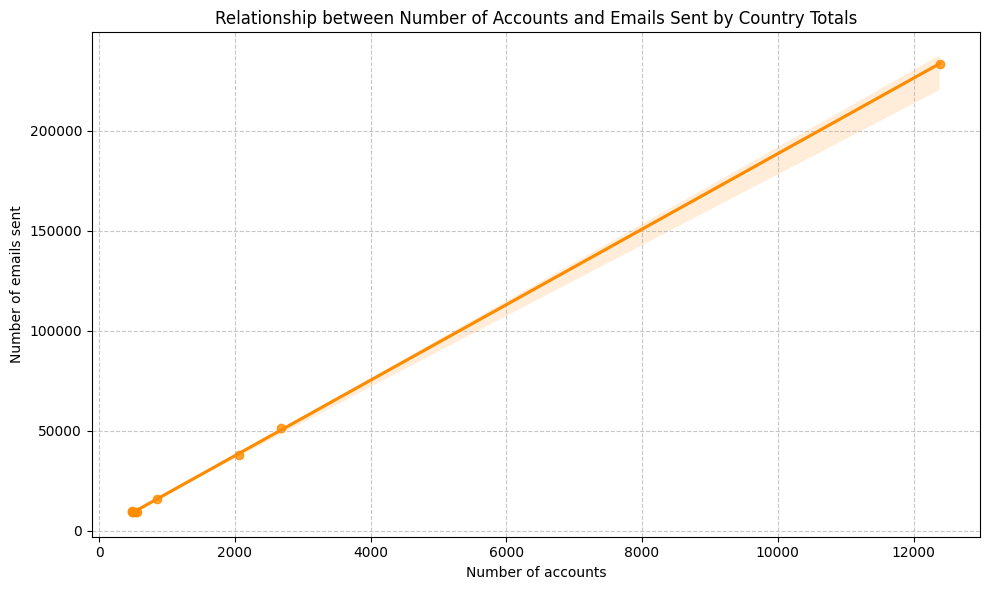

In [20]:
plt.figure(figsize=(10,6))
sns.regplot(x='accounts', y='sent_emails', data=merged_df, color='darkorange')
plt.title('Relationship between Number of Accounts and Emails Sent by Country Totals')
plt.xlabel('Number of accounts')
plt.ylabel('Number of emails sent')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
correlation = merged_df['accounts'].corr(merged_df['sent_emails'])
print(f"Correlation between number of accounts and number of sent emails by country: {correlation:.3f}")

Correlation between number of accounts and number of sent emails by country: 1.000


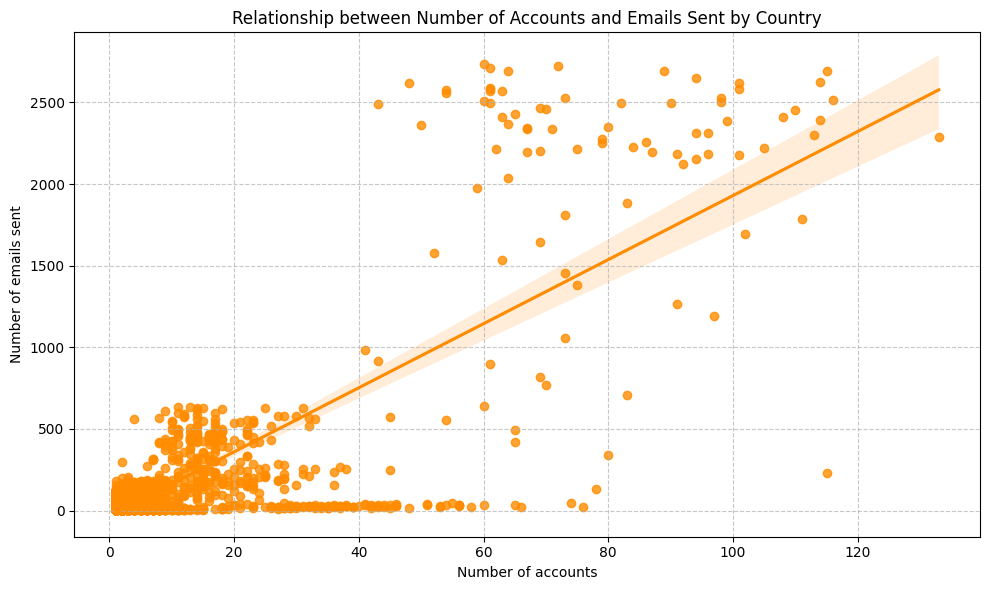

In [22]:
plt.figure(figsize=(10,6))
sns.regplot(x='account_cnt', y='sent_msg', data=df, color='darkorange')
plt.title('Relationship between Number of Accounts and Emails Sent by Country')
plt.xlabel('Number of accounts')
plt.ylabel('Number of emails sent')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
correlation = df['account_cnt'].corr(df['sent_msg'])
print(f"Correlation between number of accounts and number of sent emails: {correlation:.3f}")

Correlation between number of accounts and number of sent emails: 0.804


A correlation of 1 means a perfect positive linear relationship between the number of accounts and the number of sent emails by country.

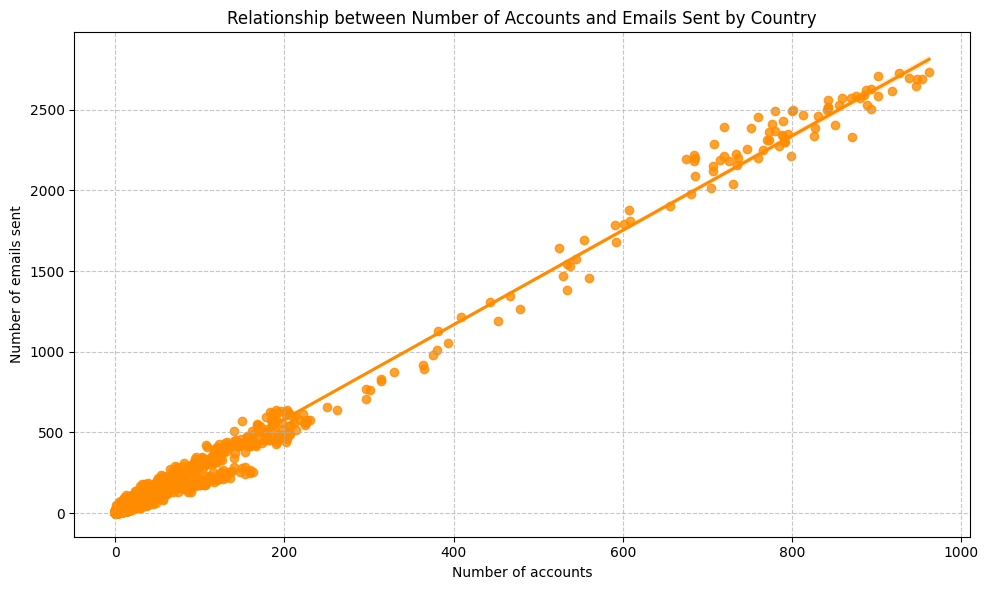

In [24]:
plt.figure(figsize=(10,6))
sns.regplot(x='open_msg', y='sent_msg', data=df, color='darkorange')
plt.title('Relationship between Number of Accounts and Emails Sent by Country')
plt.xlabel('Number of accounts')
plt.ylabel('Number of emails sent')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
correlation = df['open_msg'].corr(df['sent_msg'])
print(f"Correlation between number of accounts and number of sent emails: {correlation:.3f}")

Correlation between number of accounts and number of sent emails: 0.996


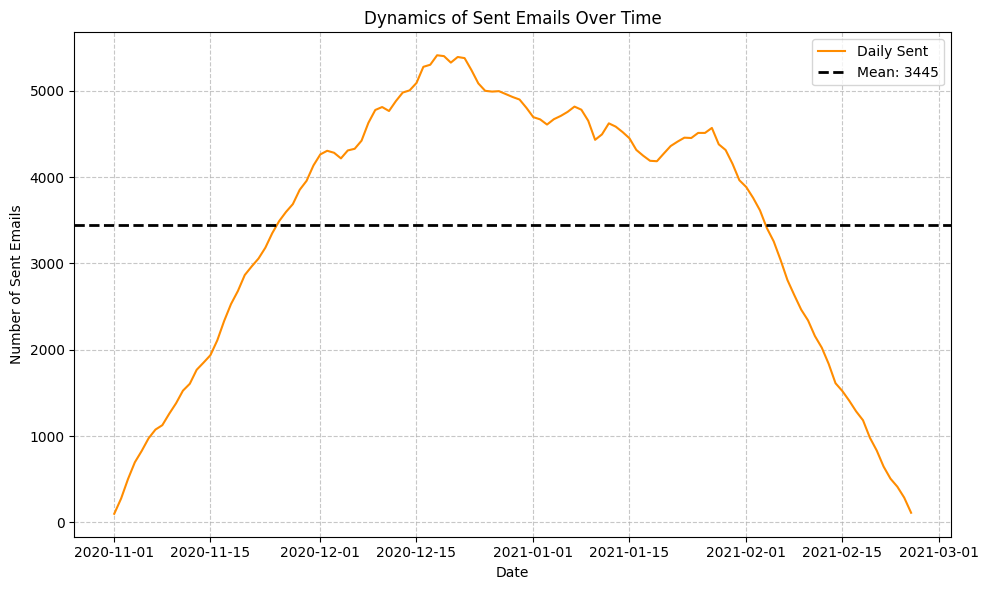

In [26]:
daily_sent = df.groupby('date')['sent_msg'].sum().reset_index()
mean_sent = daily_sent['sent_msg'].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='sent_msg', data=daily_sent, color='darkorange', label='Daily Sent')
plt.axhline(mean_sent, color='k', linestyle='--', linewidth=2, label=f'Mean: {mean_sent:.0f}')
plt.title('Dynamics of Sent Emails Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sent Emails')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

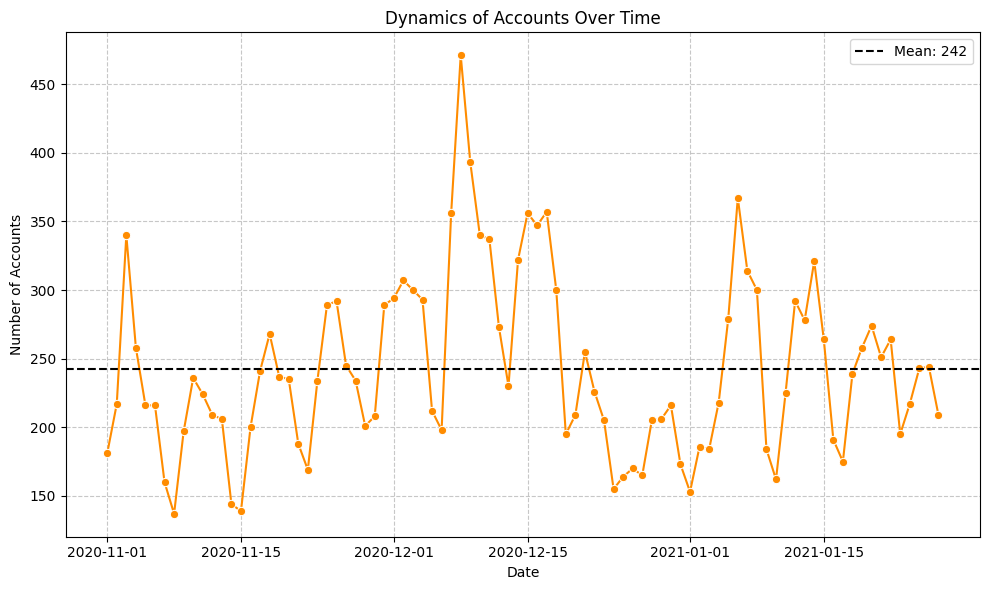

In [27]:
filtered_df = df[df['account_cnt'] > 0]
daily_accounts = filtered_df.groupby('date')['account_cnt'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='account_cnt', data=daily_accounts, marker='o', color='darkorange')

mean_val = daily_accounts['account_cnt'].mean()
plt.axhline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.0f}')

plt.title('Dynamics of Accounts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accounts')
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

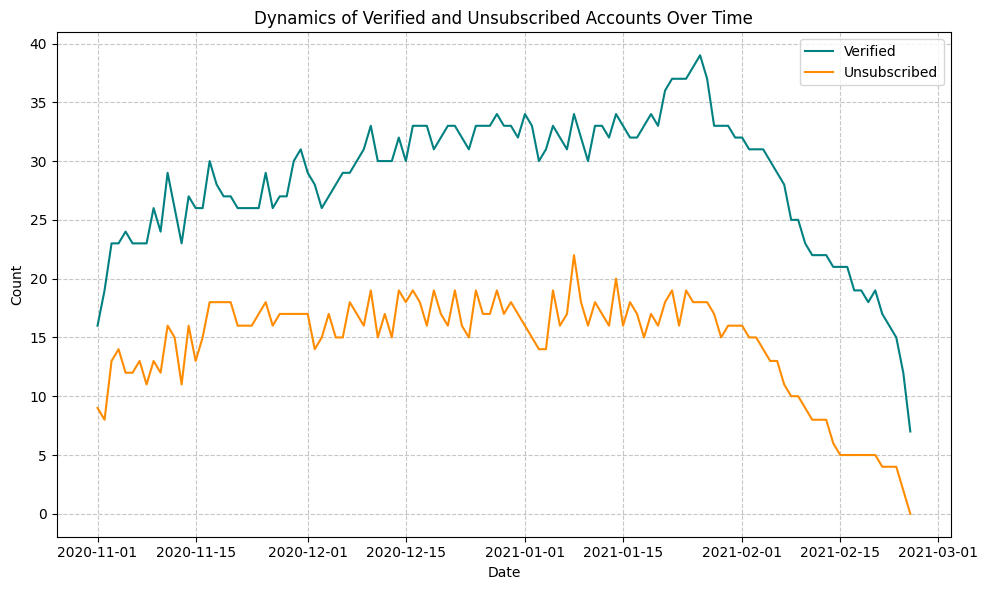

In [28]:
df_daily = df.groupby('date')[['is_verified', 'is_unsubscribed']].sum().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=df_daily, x='date', y='is_verified', label='Verified', color='teal')
sns.lineplot(data=df_daily, x='date', y='is_unsubscribed', label='Unsubscribed', color='darkorange')
plt.title('Dynamics of Verified and Unsubscribed Accounts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

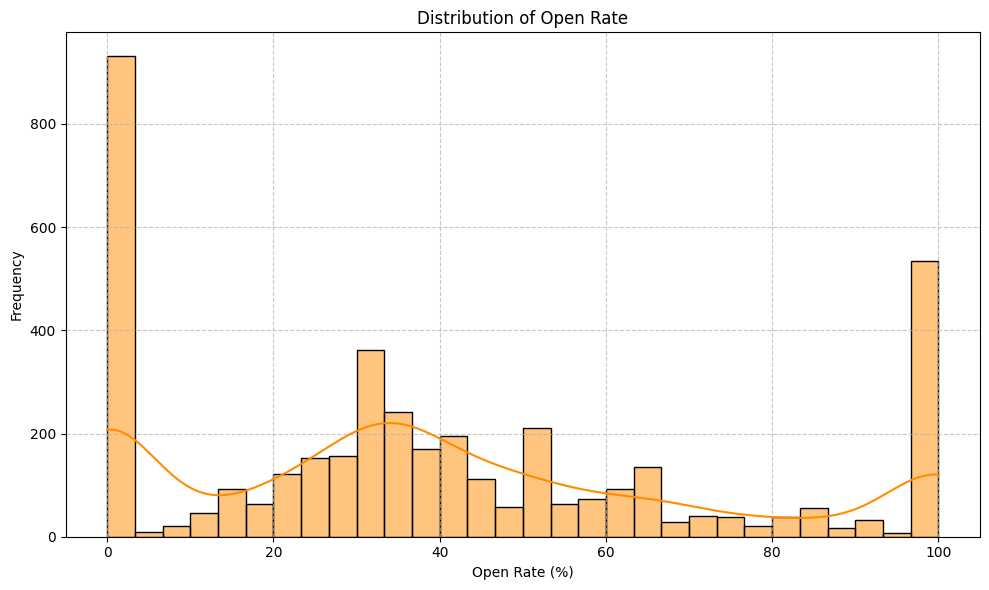

In [29]:
plt.figure(figsize=(10,6))
sns.histplot(df['open_rate'], bins=30, kde=True, color='darkorange')
plt.title('Distribution of Open Rate')
plt.xlabel('Open Rate (%)')
plt.ylabel('Frequency')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

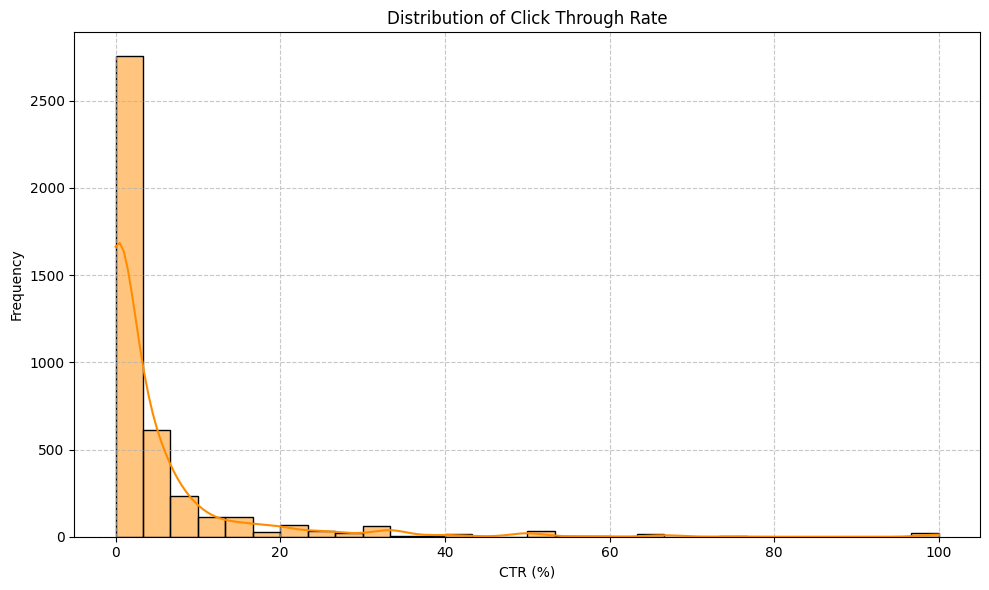

In [31]:
plt.figure(figsize=(10,6))
sns.histplot(df['ctr'], bins=30, kde=True, color='darkorange')
plt.title('Distribution of Click Through Rate')
plt.xlabel('CTR (%)')
plt.ylabel('Frequency')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

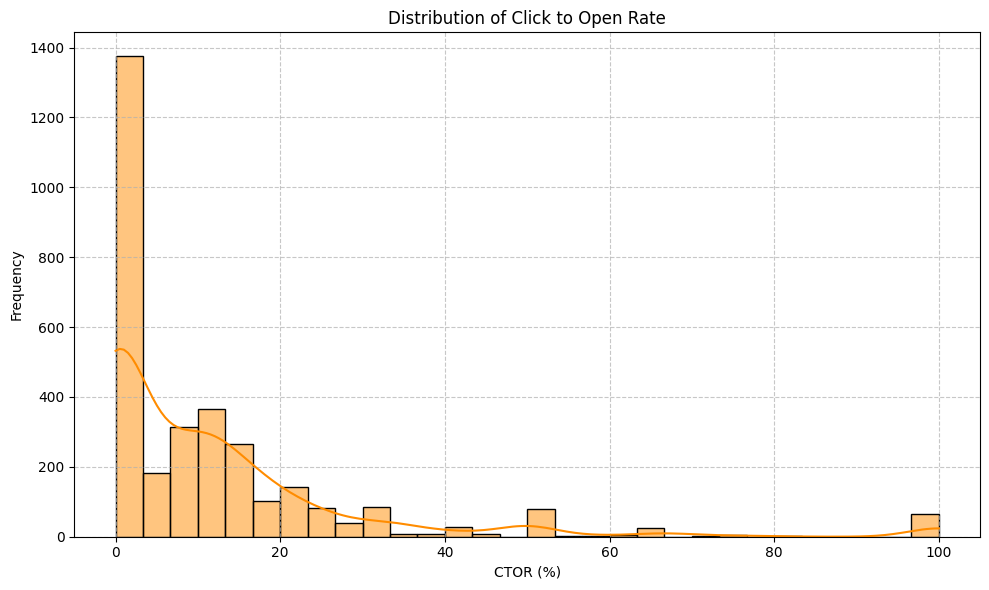

In [32]:
plt.figure(figsize=(10,6))
sns.histplot(df['ctor'], bins=30, kde=True, color='darkorange')
plt.title('Distribution of Click to Open Rate')
plt.xlabel('CTOR (%)')
plt.ylabel('Frequency')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summary

---



We used email event logs from BigQuery and aggregated them at the country level using two key metrics: total_accounts (number of unique users) and total_emails (volume of messages). This approach helps assess both the breadth (how many people are involved) and the intensity (how many emails are being sent) of communication.

The top 10 countries were ranked by total email volume to identify key communication hubs. A bar chart visualization makes it easy to detect disparities—if the drop between bars is steep, activity is concentrated in a few countries; if the bars are relatively even, engagement is more evenly distributed. These insights can help guide regional marketing strategies or infrastructure investments.